<a href="https://colab.research.google.com/github/zibro011/DataScience-Lab6/blob/main/Lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**INET 4061 Lab 6** <br>
**Adelaide Zibrowski** <br>
**October 17, 2021**

#Overview
In the following lab, we will attempt to figure out what features are most deterministic in regards to whether a customer should obtain caravan insurance or not. The data is from https://www.kaggle.com/uciml/caravan-insurance-challenge/home, and any code that is not cited or original comes from Exercise 6. We will use three modes of feature selection to create our models: stepwise regression, PCA, and feature importance. After each feature selection trial, we will generate a confusion matrix to compare to the logistic regression of all the features and the logistic regression of the other feature selection models.

#Data

In [ ]:
#import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sklearn.linear_model as lm
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#upload file
from google.colab import files
uploaded = files.upload()

Saving caravan-insurance-challenge.csv to caravan-insurance-challenge.csv


In [ ]:
#read file
import io
df = pd.read_csv(io.BytesIO(uploaded['caravan-insurance-challenge.csv']))

#Exploratory Data Analysis (EDA)

##Understand the Data

In [ ]:
#see first 5 rows
df.head()

,ORIGIN,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,MRELSA,MRELOV,MFALLEEN,MFGEKIND,MFWEKIND,MOPLHOOG,MOPLMIDD,MOPLLAAG,MBERHOOG,MBERZELF,MBERBOER,MBERMIDD,MBERARBG,MBERARBO,MSKA,MSKB1,MSKB2,MSKC,MSKD,MHHUUR,MHKOOP,MAUT1,MAUT2,MAUT0,MZFONDS,MZPART,MINKM30,MINK3045,MINK4575,...,PPERSAUT,PBESAUT,PMOTSCO,PVRAAUT,PAANHANG,PTRACTOR,PWERKT,PBROM,PLEVEN,PPERSONG,PGEZONG,PWAOREG,PBRAND,PZEILPL,PPLEZIER,PFIETS,PINBOED,PBYSTAND,AWAPART,AWABEDR,AWALAND,APERSAUT,ABESAUT,AMOTSCO,AVRAAUT,AAANHANG,ATRACTOR,AWERKT,ABROM,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,train,33,1,3,2,8,0,5,1,3,7,0,2,1,2,6,1,2,7,1,0,1,2,5,2,1,1,2,6,1,1,8,8,0,1,8,1,0,4,5,...,6,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,train,37,1,2,2,8,1,4,1,4,6,2,2,0,4,5,0,5,4,0,0,0,5,0,4,0,2,3,5,0,2,7,7,1,2,6,3,2,0,5,...,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,train,37,1,2,2,8,0,4,2,4,3,2,4,4,4,2,0,5,4,0,0,0,7,0,2,0,5,0,4,0,7,2,7,0,2,9,0,4,5,0,...,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,train,9,1,3,3,3,2,3,2,4,5,2,2,2,3,4,3,4,2,4,0,0,3,1,2,3,2,1,4,0,5,4,9,0,0,7,2,1,5,3,...,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,train,40,1,4,2,10,1,4,1,4,7,1,2,2,4,4,5,4,0,0,5,4,0,0,0,9,0,0,0,0,4,5,6,2,1,5,4,0,0,9,...,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
#see last 5 rows
df.tail()

,ORIGIN,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,MRELSA,MRELOV,MFALLEEN,MFGEKIND,MFWEKIND,MOPLHOOG,MOPLMIDD,MOPLLAAG,MBERHOOG,MBERZELF,MBERBOER,MBERMIDD,MBERARBG,MBERARBO,MSKA,MSKB1,MSKB2,MSKC,MSKD,MHHUUR,MHKOOP,MAUT1,MAUT2,MAUT0,MZFONDS,MZPART,MINKM30,MINK3045,MINK4575,...,PPERSAUT,PBESAUT,PMOTSCO,PVRAAUT,PAANHANG,PTRACTOR,PWERKT,PBROM,PLEVEN,PPERSONG,PGEZONG,PWAOREG,PBRAND,PZEILPL,PPLEZIER,PFIETS,PINBOED,PBYSTAND,AWAPART,AWABEDR,AWALAND,APERSAUT,ABESAUT,AMOTSCO,AVRAAUT,AAANHANG,ATRACTOR,AWERKT,ABROM,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
9817,test,33,1,2,4,8,0,7,2,0,5,2,2,2,6,2,0,3,6,5,0,0,1,0,4,2,0,2,4,2,4,5,4,4,2,3,6,3,6,0,...,6,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9818,test,24,1,2,3,5,1,5,1,3,4,2,4,4,4,2,2,4,4,2,0,0,3,3,3,1,1,2,5,1,7,2,6,0,3,7,2,3,3,2,...,6,0,0,0,0,0,0,0,6,0,0,0,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
9819,test,36,1,2,3,8,1,5,1,3,7,0,2,2,5,3,2,3,4,2,0,0,3,4,2,1,1,3,5,0,7,2,6,1,2,6,3,2,5,3,...,6,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
9820,test,33,1,3,3,8,1,4,2,3,7,1,2,2,3,4,1,3,5,1,1,1,2,3,3,2,2,2,4,1,4,5,6,2,2,7,2,1,4,4,...,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9821,test,8,1,2,3,2,4,3,0,3,5,2,2,0,6,3,8,0,1,8,0,0,0,0,1,4,0,5,1,0,2,7,9,0,0,2,7,0,0,7,...,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
#see how many rows and columns are in the dataset
df.shape

(9822, 87)

In [ ]:
#see how many unique values there are for each variable
pd.set_option('display.max_rows', 87)
df.nunique()

ORIGIN       2
MOSTYPE     40
MAANTHUI     9
MGEMOMV      6
MGEMLEEF     6
MOSHOOFD    10
MGODRK      10
MGODPR      10
MGODOV       6
MGODGE      10
MRELGE      10
MRELSA       8
MRELOV      10
MFALLEEN    10
MFGEKIND    10
MFWEKIND    10
MOPLHOOG    10
MOPLMIDD    10
MOPLLAAG    10
MBERHOOG    10
MBERZELF     6
MBERBOER    10
MBERMIDD    10
MBERARBG    10
MBERARBO    10
MSKA        10
MSKB1       10
MSKB2       10
MSKC        10
MSKD        10
MHHUUR      10
MHKOOP      10
MAUT1       10
MAUT2        9
MAUT0       10
MZFONDS     10
MZPART      10
MINKM30     10
MINK3045    10
MINK4575    10
MINK7512    10
MINK123M     9
MINKGEM     10
MKOOPKLA     8
PWAPART      4
PWABEDR      7
PWALAND      5
PPERSAUT     7
PBESAUT      4
PMOTSCO      6
PVRAAUT      5
PAANHANG     6
PTRACTOR     6
PWERKT       6
PBROM        6
PLEVEN      10
PPERSONG     7
PGEZONG      3
PWAOREG      5
PBRAND       9
PZEILPL      4
PPLEZIER     7
PFIETS       2
PINBOED      7
PBYSTAND     5
AWAPART      3
AWABEDR   

In [ ]:
#get dataset attributes
df.describe()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,MRELSA,MRELOV,MFALLEEN,MFGEKIND,MFWEKIND,MOPLHOOG,MOPLMIDD,MOPLLAAG,MBERHOOG,MBERZELF,MBERBOER,MBERMIDD,MBERARBG,MBERARBO,MSKA,MSKB1,MSKB2,MSKC,MSKD,MHHUUR,MHKOOP,MAUT1,MAUT2,MAUT0,MZFONDS,MZPART,MINKM30,MINK3045,MINK4575,MINK7512,...,PPERSAUT,PBESAUT,PMOTSCO,PVRAAUT,PAANHANG,PTRACTOR,PWERKT,PBROM,PLEVEN,PPERSONG,PGEZONG,PWAOREG,PBRAND,PZEILPL,PPLEZIER,PFIETS,PINBOED,PBYSTAND,AWAPART,AWABEDR,AWALAND,APERSAUT,ABESAUT,AMOTSCO,AVRAAUT,AAANHANG,ATRACTOR,AWERKT,ABROM,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
count,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,...,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.00000,9822.000000,9822.000000,9822.000000
mean,24.253207,1.108735,2.677561,2.996437,5.779067,0.700672,4.637650,1.050092,3.262981,6.188964,0.873142,2.286602,1.887294,3.237324,4.302891,1.484525,3.307269,4.592038,1.898799,0.403278,0.545714,2.877113,2.226532,2.291183,1.650682,1.595093,2.204744,3.742211,1.068214,4.187742,4.819487,6.022501,1.335980,1.956730,6.254327,2.750662,2.577072,3.505498,2.739462,0.808491,...,2.956424,0.054877,0.170841,0.008858,0.019344,0.093565,0.011505,0.215027,0.202301,0.011505,0.018733,0.023315,1.849420,0.001629,0.015272,0.025351,0.016697,0.045408,0.400020,0.014050,0.021279,0.557218,0.011098,0.040216,0.002240,0.011403,0.034413,0.005192,0.071065,0.079821,0.004582,0.007941,0.004276,0.574018,0.000916,0.005091,0.03146,0.008450,0.013846,0.059662
std,12.918058,0.412101,0.780701,0.804660,2.874148,1.015107,1.721212,1.011156,1.606287,1.896070,0.961955,1.710674,1.779238,1.609139,1.984152,1.645968,1.723377,2.279839,1.814406,0.786792,1.106349,1.846703,1.748025,1.684008,1.742410,1.321487,1.534163,1.944900,1.298229,3.093127,3.093541,1.543980,1.213627,1.596842,2.000374,2.002960,2.073125,1.871365,1.950625,1.173771,...,2.921736,0.566108,0.888518,0.237556,0.200885,0.604350,0.215408,0.810899,0.910574,0.188699,0.213712,0.375350,1.881271,0.057058,0.244210,0.157198,0.211487,0.396983,0.492001,0.126058,0.144319,0.608575,0.129928,0.223622,0.068402,0.116251,0.249706,0.109954,0.267432,0.384431,0.067535,0.088764,0.071224,0.561255,0.030258,0.077996,0.20907,0.092647,0.117728,0.236872
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,10.000000,1.000000,2.000000,2.000000,3.000000,0.000000,4.000000,0.000000,2.000000,5.000000,0.000000,1.000000,0.000000,2.000000,3.000000,0.000000,2.000000,3.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1

From the code above, we can see that our dataset has 9822 rows and 87 columns. We can also see how many unique values there are for each variable. Since this dataset is large, and we have a text summary at our disposal, it is better to take advantage of that. However, we could use the unique function on each column to see all the possible values for each variable. Many of the data values are represented with keys that are listed in the dataset description, so the values like min, max, and mean do not have much value to us here.

##Clean the Data

In [ ]:
#drop any rows that contain a null value in any column
df= df.dropna(how = 'any', axis = 0)
df.shape

(9822, 87)

In [ ]:
#drop any rows that contain an outlier in any column
#here I define an outlier as a value that is more than 3 standard deviations away from the mean
col = df.iloc[:,1:]
df[(np.abs(stats.zscore(col)) < 3)]
df.shape

(9822, 87)

I used code from https://stackoverflow.com/questions/44548721/remove-row-with-null-value-from-pandas-data-frame/44548976 to drop any rows that contained a null value in any column. When I reprinted the shape, we can see that no rows were dropped, so the dataset did not contain any null values. Then, I used code from https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame#comment97037997_23202269 to drop any rows that contained an outlier in any column. I defined an outlier as a value that was more than 3 standard deviations from the mean. Again, when I reprinted the shape, we can see that no rows were dropped, so there were no outlier datapoints in the dataframe. This is obvious because when we look at the dataframe attributes, any value that is over 3 standard deviations from the mean, would be outside of the max. Therefore, no outliers can exist under these circumstances.

#Models

In [ ]:
#split data into training and test sets
grouped = df.groupby(df.ORIGIN)
df_train = grouped.get_group('train')
df_test = grouped.get_group('test')

In [ ]:
#create two datasets that include all independent variables
train_x = df_train.iloc[:,1:86]
test_x = df_test.iloc[:,1:86]

In [ ]:
#create two datasets that include only the target variable
train_y = df_train.iloc[:,86]
test_y = df_test.iloc[:,86]

##Logistic Regression (Base Model)

In [ ]:
#create logistic regression model
log_reg = lm.LogisticRegression()
log_reg.fit(train_x,train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
#make predicitions using model
y_pred = log_reg.predict(test_x)

In [ ]:
#print confusion matrix
confusion_matrix(test_y, y_pred)

array([[3760,    2],
       [ 235,    3]])

The confusion matrix shows us that we have 3760 true positives, 2 false positives, 235 false negatives, and 3 true negatives. This means that our model produced a large amount of Type II Errors. The good news is, Type II errors are considered less detrimental than Type I Errors. However, that doesn't change the fact that our model is simply unaffective at making predictions, so it will not be useful in solving our business problem.

##Logistic Regression with Stepwise Feature Selection <br>

In [ ]:
#reload unedited dataframe
df = pd.read_csv(io.BytesIO(uploaded['caravan-insurance-challenge.csv']))

In [ ]:
df = df.drop(['ORIGIN'], axis=1)

In [ ]:
X = df.iloc[:,1:85]
y = df.iloc[:,85]

In [ ]:
#perform stepwise selection on variables
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
#            best_feature = new_pval.argmin()
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(X, y)

print('resulting features:')
print(result)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if sys.path[0] == '':


Add  PPERSAUT                       with p-value 2.14684e-42
Add  MKOOPKLA                       with p-value 1.36739e-21
Add  PWAPART                        with p-value 3.66711e-15
Add  APLEZIER                       with p-value 8.20766e-15
Add  MOPLHOOG                       with p-value 4.25236e-06
Add  PBRAND                         with p-value 3.92829e-06
Add  MBERBOER                       with p-value 8.31838e-06
Add  MRELGE                         with p-value 1.41977e-05
Add  PWALAND                        with p-value 0.000361295
Add  ABRAND                         with p-value 0.000937601
Add  AZEILPL                        with p-value 0.00153041
Add  MINK123M                       with p-value 0.00152554
Add  PBYSTAND                       with p-value 0.00243579
Add  PGEZONG                        with p-value 0.00485648
Add  AGEZONG                        with p-value 0.00450709
Add  MHHUUR                         with p-value 0.00630075
resulting features:
['PPERSAUT

In [ ]:
# Let us modify our data structures to fit the new features.
reduced_train_df_X = train_x[train_x.columns.intersection(result)]
reduced_test_x_df = test_x[test_x.columns.intersection(result)]

In [ ]:
#create logistic regression model
log_reg = lm.LogisticRegression()
log_reg.fit(reduced_train_df_X,train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
#make predicitions using model
reduced_y_pred = log_reg.predict(reduced_test_x_df)

In [ ]:
#print confusion matrix
confusion_matrix(test_y, reduced_y_pred)

array([[3759,    3],
       [ 235,    3]])

The confusion matrix shows us that after performing stepwise regression and going down to only 16 features, we have 3759 true positives, 3 false positives, 235 false negatives, and 3 true negatives. That is worse than our previous model by 1 instance. That means that the 16 features that were selected using stepwise regression were not helpful in improving our model.

##Random Forest Based On Principal Component Analysis Feature Selection
In addition to code from Exercise 6, I used information from https://dwbi1.wordpress.com/2021/04/16/logistic-regression-with-pca-in-python/ to complete this section.

In [ ]:
#start over with fresh dataset
df = pd.read_csv(io.BytesIO(uploaded['caravan-insurance-challenge.csv']))

In [ ]:
all_vars = df.drop(['ORIGIN'], axis=1)
x_vars = all_vars.drop(['CARAVAN'], axis=1)
y = df['CARAVAN']

print(y[0:5])
all_vars.head()

0    0
1    0
2    0
3    0
4    0
Name: CARAVAN, dtype: int64


,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,MRELSA,MRELOV,MFALLEEN,MFGEKIND,MFWEKIND,MOPLHOOG,MOPLMIDD,MOPLLAAG,MBERHOOG,MBERZELF,MBERBOER,MBERMIDD,MBERARBG,MBERARBO,MSKA,MSKB1,MSKB2,MSKC,MSKD,MHHUUR,MHKOOP,MAUT1,MAUT2,MAUT0,MZFONDS,MZPART,MINKM30,MINK3045,MINK4575,MINK7512,...,PPERSAUT,PBESAUT,PMOTSCO,PVRAAUT,PAANHANG,PTRACTOR,PWERKT,PBROM,PLEVEN,PPERSONG,PGEZONG,PWAOREG,PBRAND,PZEILPL,PPLEZIER,PFIETS,PINBOED,PBYSTAND,AWAPART,AWABEDR,AWALAND,APERSAUT,ABESAUT,AMOTSCO,AVRAAUT,AAANHANG,ATRACTOR,AWERKT,ABROM,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,33,1,3,2,8,0,5,1,3,7,0,2,1,2,6,1,2,7,1,0,1,2,5,2,1,1,2,6,1,1,8,8,0,1,8,1,0,4,5,0,...,6,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,2,2,0,4,5,0,5,4,0,0,0,5,0,4,0,2,3,5,0,2,7,7,1,2,6,3,2,0,5,2,...,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,2,4,4,4,2,0,5,4,0,0,0,7,0,2,0,5,0,4,0,7,2,7,0,2,9,0,4,5,0,0,...,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,2,2,2,3,4,3,4,2,4,0,0,3,1,2,3,2,1,4,0,5,4,9,0,0,7,2,1,5,3,0,...,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,1,2,2,4,4,5,4,0,0,5,4,0,0,0,9,0,0,0,0,4,5,6,2,1,5,4,0,0,9,0,...,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
# standardize the data 
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(x_vars)
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

Covariance matrix 
[[ 1.00010182 -0.04033167 -0.0065945  ... -0.0255354  -0.01633792
  -0.04375385]
 [-0.04033167  1.00010182 -0.00431565 ... -0.01252764  0.0319394
  -0.005852  ]
 [-0.0065945  -0.00431565  1.00010182 ...  0.01848839  0.01092878
   0.03085877]
 ...
 [-0.0255354  -0.01252764  0.01848839 ...  1.00010182  0.00204416
   0.00712214]
 [-0.01633792  0.0319394   0.01092878 ...  0.00204416  1.00010182
   0.01727922]
 [-0.04375385 -0.005852    0.03085877 ...  0.00712214  0.01727922
   1.00010182]]


In [ ]:
#Perform eigendecomposition on covariance matrix
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[-1.80741073e-01  1.90012238e-01 -1.08200120e-02 ... -1.19823729e-02
  -1.86481597e-03 -3.99575753e-04]
 [ 6.86446049e-05 -9.97766755e-03  1.42353206e-02 ... -5.62264287e-03
  -1.64017734e-03 -1.88420999e-03]
 [ 1.21471618e-01  2.78081107e-01  9.89312897e-02 ...  1.32823262e-03
   4.33591381e-03 -1.66503718e-03]
 ...
 [ 1.26127757e-02 -1.12937278e-02  2.14048183e-02 ...  9.27489842e-03
   2.15410748e-02 -4.32546502e-03]
 [ 1.32624344e-02 -5.62562226e-03 -1.97657957e-02 ...  1.93069813e-03
   1.94621753e-03 -5.83645630e-03]
 [ 2.36962778e-02  1.36883444e-02 -4.79283762e-02 ...  4.76677274e-02
  -1.50691498e-02 -3.00046503e-02]]

Eigenvalues 
[9.38114298e+00 4.90789884e+00 3.98336652e+00 3.34322942e+00
 2.92824840e+00 2.64384083e+00 2.26219960e+00 2.23659410e+00
 2.14010672e+00 2.10857567e+00 2.00996208e+00 1.95746407e+00
 1.91389055e+00 1.90310544e+00 1.86888982e+00 1.84630241e+00
 1.79586996e+00 1.81596659e+00 1.72663381e+00 1.68813177e+00
 1.55440514e+00 1.62031830e+00 

In [ ]:
for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

Everything ok!


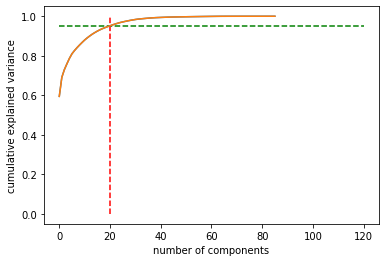

In [ ]:
from sklearn.decomposition import PCA
pca = PCA().fit(all_vars)
plt.hlines(y=0.95, xmax=120, xmin=0, colors="g", linestyles="--")
plt.vlines(x=20, ymax=1, ymin=0, colors="r", linestyles="--")
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

As we can see in the graph above, we need 20 components to retain 95% explained variance.

In [ ]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=42)

In [ ]:
from sklearn.decomposition import IncrementalPCA
# Train the PCA model 
pca_final = IncrementalPCA(n_components=20)
df_train_pca = pca_final.fit_transform(X_train)
 
# Note that the above can be automated like this: (without using plot)
pca_final = PCA(0.95)
df_train_pca = pca_final.fit_transform(X_train)

In [ ]:
# Apply PCA model to the test data
df_test_pca = pca_final.transform(X_test)
 
# Train the Logistic Regression model
LR_PCA_Learner = lm.LogisticRegression()
LR_PCA_Model = LR_PCA_Learner.fit(df_train_pca, y_train)

In [ ]:
#make predicitions using model
pca_pred_y = LR_PCA_Learner.predict(df_train_pca)

array([[-4.99209030e+00, -2.22960697e+00,  6.31655500e+00, ...,
         1.00723935e-01,  2.67516372e-01, -6.02754399e-02],
       [-5.47103086e+00,  7.83232032e-02, -6.30032408e+00, ...,
        -3.19168777e-01,  4.03542541e-01, -1.04134402e-03],
       [-7.37494566e+00, -2.41352999e+00, -5.49576264e+00, ...,
        -3.98129698e-01, -1.41847383e+00, -8.88020844e-02],
       ...,
       [ 1.35144051e+01,  1.89839014e+00,  1.07233405e+00, ...,
        -3.79270416e-01, -3.03126696e+00, -5.04383736e-03],
       [ 3.78515509e-01, -1.16925148e+00, -1.39798008e+00, ...,
         3.61505228e-01, -3.46868671e-01, -5.02722812e-01],
       [-1.11268768e+01,  4.06366028e+00,  4.34876733e+00, ...,
        -2.31137507e-01,  1.16333402e+00,  1.17898690e-01]])

In [ ]:
#print confusion matrix
confusion_matrix(test_y, reduced_y_pred)

array([[3759,    3],
       [ 235,    3]])

The confusion matrix shows us that after performing PCA analysis and going down to only 20 features, we have 3759 true positives, 3 false positives, 235 false negatives, and 3 true negatives. This is exactly the same as our previous model, so we can conclude that in this case, PCA and stepwise regression are equally effective, but neither of them make our model more successful.

##Random Forest Based On Feature Importance Feature Selection
I used information from https://mljar.com/blog/feature-importance-in-random-forest/ to complete the feature selection below.

In [ ]:
#start over with fresh dataset
df = pd.read_csv(io.BytesIO(uploaded['caravan-insurance-challenge.csv']))

In [ ]:
#split data into training and test sets
grouped = df.groupby(df.ORIGIN)
df_train = grouped.get_group('train')
df_test = grouped.get_group('test')

In [ ]:
#create two datasets that include all independent variables
train_x = df_train.iloc[:,1:86]
test_x = df_test.iloc[:,1:86]

In [ ]:
#create two datasets that include only the target variable
train_y = df_train.iloc[:,86]
test_y = df_test.iloc[:,86]

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100)
rf.fit(train_x, train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
rf.feature_importances_

array([4.45456519e-02, 5.27846430e-03, 8.17747736e-03, 1.04384099e-02,
       1.54297181e-02, 1.04676044e-02, 2.06590166e-02, 1.42950282e-02,
       2.18793836e-02, 1.36071567e-02, 9.18782505e-03, 9.45620185e-03,
       1.49498985e-02, 1.80546769e-02, 1.69586888e-02, 1.84088181e-02,
       1.96720478e-02, 1.81664209e-02, 1.70078489e-02, 1.17940381e-02,
       6.49708308e-03, 2.11941979e-02, 1.93353553e-02, 2.09698461e-02,
       1.41414573e-02, 1.63011699e-02, 1.46979655e-02, 1.70525187e-02,
       1.35879135e-02, 1.19285103e-02, 1.21849690e-02, 1.29016422e-02,
       1.36338302e-02, 1.12602427e-02, 1.01337979e-02, 1.11737070e-02,
       1.40564726e-02, 1.97970955e-02, 1.72642121e-02, 1.74041514e-02,
       6.20266914e-03, 1.26894649e-02, 2.85692401e-02, 3.35526417e-02,
       2.62208701e-03, 2.90011563e-04, 4.04542250e-02, 1.18284214e-03,
       7.47475188e-03, 2.08291433e-05, 2.54258258e-03, 3.02995916e-03,
       2.20470385e-05, 7.84118347e-03, 1.08109435e-02, 8.08445714e-05,
      

Text(0.5, 0, 'Random Forest Feature Importance')

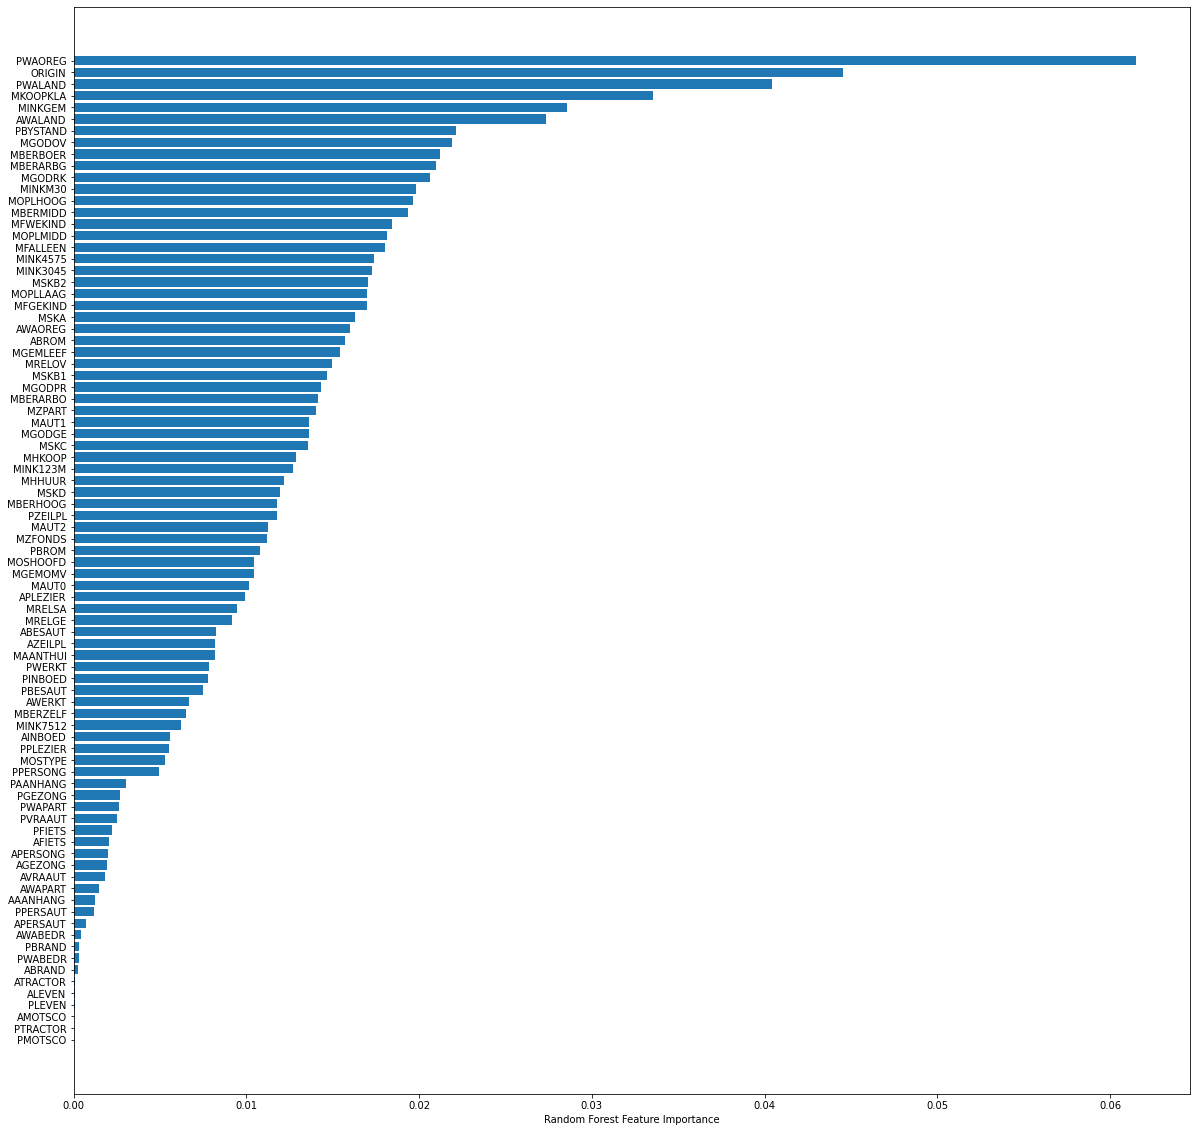

In [ ]:
#plot the feature importances so it is easier to interpret
fig, ax = plt.subplots(figsize=(20,20))
sorted_idx = rf.feature_importances_.argsort()
plt.barh(df.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [ ]:
#keep 20 most important features
newdf = df.drop(columns= ['MOSTYPE', 'MAANTHUI', 'MGEMOMV', 'MGEMLEEF', 'MOSHOOFD', 'MGODPR', 'MGODGE', 'MRELGE', 'MRELSA', 'MRELOV', 'MFGEKIND',
       'MBERHOOG', 'MBERZELF', 'MBERARBO',
       'MSKA', 'MSKB1', 'MSKC', 'MSKD', 'MHHUUR', 'MHKOOP', 'MAUT1',
       'MAUT2', 'MAUT0', 'MZFONDS', 'MZPART', 'MINK7512', 'MINK123M', 'PWAPART',
       'PWABEDR', 'PPERSAUT', 'PBESAUT', 'PMOTSCO', 'PVRAAUT',
       'PAANHANG', 'PTRACTOR', 'PWERKT', 'PBROM', 'PLEVEN', 'PPERSONG',
       'PGEZONG', 'PBRAND', 'PZEILPL', 'PPLEZIER', 'PFIETS',
       'PINBOED', 'AWAPART', 'AWABEDR', 'APERSAUT',
       'ABESAUT', 'AMOTSCO', 'AVRAAUT', 'AAANHANG', 'ATRACTOR', 'AWERKT',
       'ABROM', 'ALEVEN', 'APERSONG', 'AGEZONG', 'AWAOREG', 'ABRAND',
       'AZEILPL', 'APLEZIER', 'AFIETS', 'AINBOED', 'ABYSTAND'])

In [ ]:
#split data into training and test sets
grouped = newdf.groupby(newdf.ORIGIN)
df_train = grouped.get_group('train')
df_test = grouped.get_group('test')

In [ ]:
#create two datasets that include all independent variables
train_x = df_train.iloc[:,1:86]
test_x = df_test.iloc[:,1:86]

In [ ]:
#create two datasets that include only the target variable
train_y = df_train.iloc[:,21]
test_y = df_test.iloc[:,21]

In [ ]:
#create logistic regression model
rmf = lm.LogisticRegression()
rmf.fit(train_x,train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
#make predicitions using model
new_y_pred = rmf.predict(test_x)

In [ ]:
#print confusion matrix
confusion_matrix(test_y, new_y_pred)

array([[3762,    0],
       [   0,  238]])

The confusion matrix shows us that after performing feature importance feature selection and going down to only 20 features, we have 3762 true positives, 0 false positives, 0 false negatives, and 238 true negatives. Our model performed with no errors! We can use these chosen features as deterministic features for our independent variable, thus answering our business question.

#Conclusions
In order to realize which features had the most influence on whether a customer should be given caravan insurance or not, we first made a logistic regression model with all the features we had available. Then, we performed feature selection using stepwise regression, PCA, and feature importance. Stepwise regression and PCA both made our logistic regression model worse, but feature importance made our model predict caravan values with 0 error. Therefore, we can conclude that the most important factors in determining whether a customer should have caravan insurance are: 'MGODRK', 'MGODOV', 'MFALLEEN', 'MFWEKIND', 'MOPLHOOG','MOPLMIDD', 'MOPLLAAG', 'MBERBOER', 'MBERMIDD', 'MBERARBG', 'MSKB2','MINKM30', 'MINK3045', 'MINK4575', 'MINKGEM', 'MKOOPKLA', 'PWALAND', 'PWAOREG', 'PBYSTAND', and 'AWALAND'. These correspond to the following features: Roman Catholic, other religion, singles, household with children, high level education, medium level education, lower level education, farmer, middle management, skilled labourers, social class B2, income below 30,000, income between 30,000 - 45,000, income 45,000 - 75,000, average income, purchasing power class, contribution third party insurance (agriculture), contribution disability insurance policies, contribution social security insurance policies, and number of third party insurance (agriculture). <br> <br>

We can generalize that even further by grouping some of those features. For example, since all education levels are included, we can say that education level is actually not a contributing factor. We can also group income groups together to just say income between 30,000 - 75,000. We can report the specific determining features that I listed above, but a general answer to our business question would be: Some of the most determining factors when it comes to whether a customer should buy caravan insurance or not, include: Roman Catholics, other religions, singles, households with children, farmers, middle management, skilled labourer, social class B2, income between 30,000 - 75,000, number and contribution third party insurance (agrilculture), contribution disability insurance policies, and contribution social security insurance policies.